# Image classification

### Descripción
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


### Objetivo
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
  1. Modelo con capas densas.

  2. Modelo con capas convolucionales y densas.

  3. Modelo que incluya bloques residuales identidad:

  4. Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

## 1. Configurar entorno de trabajo

### 1.1. Instalar librerías necesarias

In [ ]:
!pip install -q gdown
!pip install Pillow

### 1.2. Importar las librerías necesarias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Dropout, Rescaling
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Add
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder
from skimage import io
import cv2
import os
import random
import zipfile
import gdown
from pathlib import Path
import warnings


warnings.filterwarnings("ignore")

### 1.3 - Descargar y extraer el dataset

In [ ]:
# Descargar el dataset
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

# Extraerlo
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=be99cce9-3e3c-45fc-8f17-204b16ecff1f
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:09<00:00, 37.9MB/s]


### 1.4. Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## 2. Análisis Exploratorio de los Datos (EDA)

Se comenzará haciendo un análisis explotarorio del dataset para conocer sus características principales y evaluar si es necesario hacer algún proceso antes de comenzar.

### Dataset

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos:

- Train: Alrededor de 14,000 imágenes para entrenamiento.

- Test: Alrededor de 3,000 imágenes para evaluación del modelo.

- Prediction: Alrededor de 7,000 imágenes para predicción final.

### 2.1. Definir directorios del dataset

In [ ]:
# Definir el directorio dónde se encuentra el dataset
dataset_dir = "/content/TP1-3"

# Definir los directorios de train y test
train_dir = os.path.join(dataset_dir, "seg_train", "seg_train")
test_dir = os.path.join(dataset_dir, "seg_test", "seg_test")

### 2.2. Generadores de datos y aumentadores

In [ ]:
# Aumentadores y generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Escalar los valores de píxel al rango [0,1]
    shear_range=0.2,  # Rango de deformación por cizallamiento
    zoom_range=0.2,  # Rango de aumento de zoom
    horizontal_flip=True,  # Girar aleatoriamente las imágenes horizontalmente
    validation_split=0.2  # Separar los datos de entrenamiento en 80% para training y 20% para validación
)

# Generador de datos para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directorio de entrenamiento
    target_size=(150, 150),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    subset='training'  # Especificar que este es el conjunto de entrenamiento
)

# Generador de datos para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Directorio de entrenamiento
    target_size=(150, 150),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    subset='validation'  # Especificar que este es el conjunto de validación
)

# Preprocesar los datos de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de datos para el conjunto de pruebas
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directorio de pruebas
    target_size=(150, 150),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    shuffle=False  # Mantener el orden para la evaluación
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### 2.3. Análisis del dataset

In [ ]:
# Función para cargar y mostrar una imagen
def show_image(image_path):
    image = cv2.imread(str(image_path))
    label = image_path.parent.name
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Imagen de ejemplo para la clase: {label}')
    plt.show()

# Función para verificar el tamaño de las imágenes
def check_image_sizes(image_dir):
    image_sizes = set()
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        image_sizes.add((height, width))
    return image_sizes

# Función para verificar el formato de las imágenes
def check_image_formats(image_dir):
    image_formats = set()
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        image_formats.add(image.shape[2])  # 2 para obtener el número de canales de color
    return image_formats

# Función para verificar el balance de clases
def check_class_balance(image_dir):
    class_counts = {}
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

Clase: buildings
Tamaños de imágenes encontrados: {(124, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


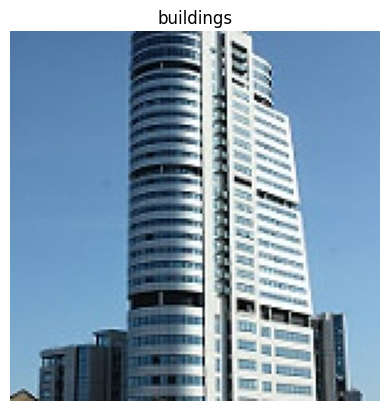

----------------------------------------------------


Clase: forest
Tamaños de imágenes encontrados: {(115, 150), (113, 150), (108, 150), (133, 150), (150, 150), (135, 150), (136, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


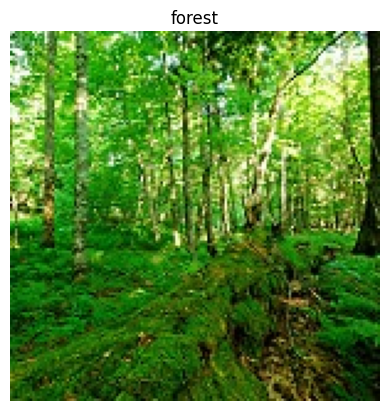

----------------------------------------------------


Clase: glacier
Tamaños de imágenes encontrados: {(143, 150), (135, 150), (146, 150), (120, 150), (134, 150), (142, 150), (105, 150), (111, 150), (149, 150), (150, 150), (123, 150), (102, 150), (97, 150), (119, 150), (76, 150), (110, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


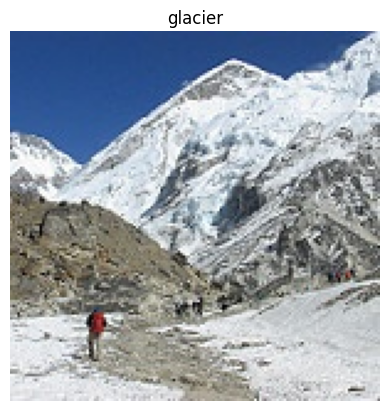

----------------------------------------------------


Clase: mountain
Tamaños de imágenes encontrados: {(143, 150), (103, 150), (146, 150), (145, 150), (142, 150), (134, 150), (113, 150), (136, 150), (144, 150), (100, 150), (150, 150), (123, 150), (135, 150), (81, 150), (141, 150), (147, 150), (131, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


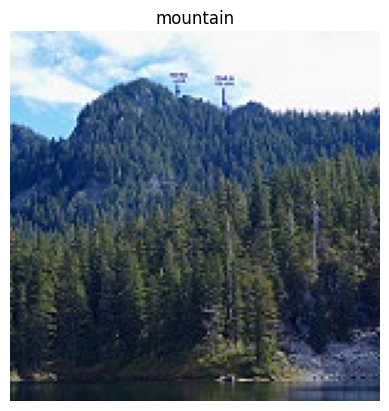

----------------------------------------------------


Clase: sea
Tamaños de imágenes encontrados: {(140, 150), (113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


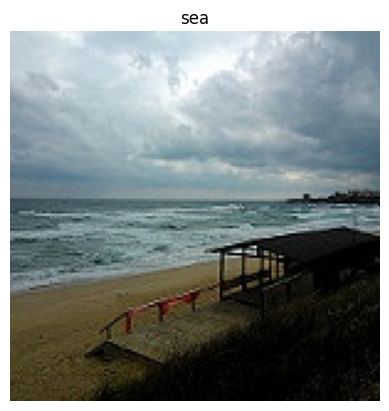

----------------------------------------------------


Clase: street
Tamaños de imágenes encontrados: {(113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


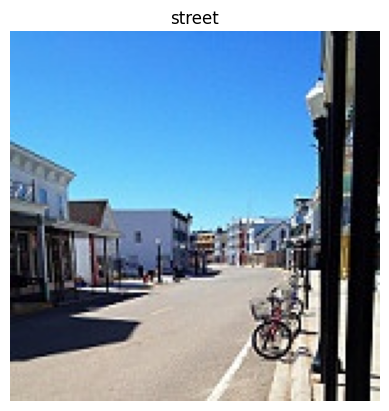

----------------------------------------------------




In [ ]:
def show_image(image_path):
    image = cv2.imread(image_path)
    label = os.path.basename(os.path.dirname(image_path))  # Get the parent directory name
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

# Get the class names
class_names = list(train_generator.class_indices.keys())

for image_class in class_names:
    print(f'Clase: {image_class}')
    image_directory = os.path.join(train_dir, image_class)  # Adjust path based on train_dir
    # Verificar tamaño de imágenes
    image_sizes = check_image_sizes(image_directory)
    print("Tamaños de imágenes encontrados:", image_sizes)

    # Verificar formato de imágenes
    image_formats = check_image_formats(image_directory)
    print("Formatos de imágenes encontrados. Número de canales de color:", image_formats)

    # Get list of test image paths
    test_image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith('.jpg')]
    sample_image_path = random.choice(test_image_paths)
    show_image(sample_image_path)

    print('----------------------------------------------------')
    print('\n')


In [ ]:
# Verificar balance de clases
class_balance = check_class_balance(train_dir)
print("Balance de clases:", class_balance)

Balance de clases: {'mountain': 2512, 'glacier': 2404, 'street': 2382, 'forest': 2271, 'buildings': 2191, 'sea': 2274}


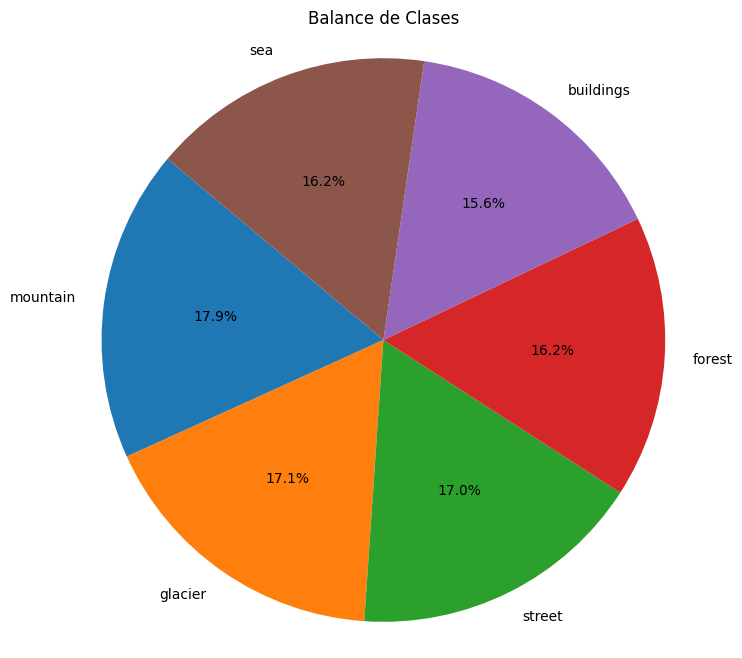

In [ ]:
# Extraer nombres de clases y sus respectivos valores
class_names = list(class_balance.keys())
class_counts = list(class_balance.values())

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Balance de Clases')
plt.axis('equal')  # Hace que el gráfico de torta sea circular
plt.show()

### 2.4 - Visualización de imágenes de ejemplo

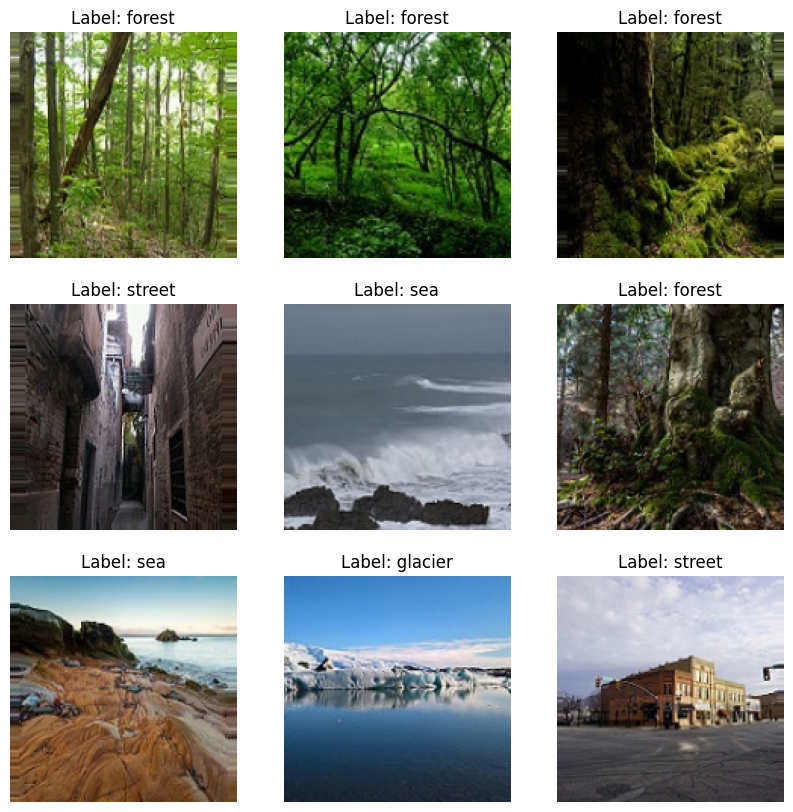

In [ ]:
# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Mostrar algunas imagenes de ejemplo del traing set con etiquetas
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    label_index = sample_labels[i].argmax()
    plt.title(f'Label: {class_labels[label_index]}')
    plt.axis("off")
plt.show()

## 3. Arquitecturas de Red

### 3.1 - Redes densas

#### 3.1.1. Definición del modelo

In [ ]:
def build_classification_model(num_layers, num_neurons, input_shape):
    i = Input(input_shape, dtype=tf.float32)
    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    model = keras.Sequential()
    model.add(Flatten(input_shape=input_shape))  # Aplana las imágenes antes de la capa densa

    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))  # Capas ocultas

    model.add(keras.layers.Dropout(0.2))
    model.add(Dense(6, activation='softmax'))  # Capa de salida para clasificación multiclase
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### 3.1.2. Construir el modelo

In [ ]:
input_shape = (150, 150, 3)  # Size of the images
num_layers = 7
num_neurons = 128

model_dnn = build_classification_model(num_layers, num_neurons, input_shape)

#### 3.1.3. Resumen del modelo

In [ ]:
model_dnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 67500)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               8640128   
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 128)              

#### 3.1.4. Se entrena el modelo

In [ ]:
history_dnn = model_dnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
351/351 [==============================] - 132s 372ms/step - loss: 1.5995 - accuracy: 0.3661 - val_loss: 1.3571 - val_accuracy: 0.4818
Epoch 2/20
351/351 [==============================] - 125s 356ms/step - loss: 1.3540 - accuracy: 0.4693 - val_loss: 1.3033 - val_accuracy: 0.4979
Epoch 3/20
351/351 [==============================] - 137s 389ms/step - loss: 1.2798 - accuracy: 0.5010 - val_loss: 1.2105 - val_accuracy: 0.5353
Epoch 4/20
351/351 [==============================] - 125s 356ms/step - loss: 1.2405 - accuracy: 0.5170 - val_loss: 1.1697 - val_accuracy: 0.5528
Epoch 5/20
351/351 [==============================] - 126s 358ms/step - loss: 1.2011 - accuracy: 0.5289 - val_loss: 1.2119 - val_accuracy: 0.5367
Epoch 6/20
351/351 [==============================] - 127s 362ms/step - loss: 1.1905 - accuracy: 0.5423 - val_loss: 1.1830 - val_accuracy: 0.5417
Epoch 7/20
351/351 [==============================] - 137s 390ms/step - loss: 1.1713 - accuracy: 0.5514 - val_loss: 1.2167 -

#### 3.1.5. Graficar el Acuracy y el Loss de entrenamiento y validación

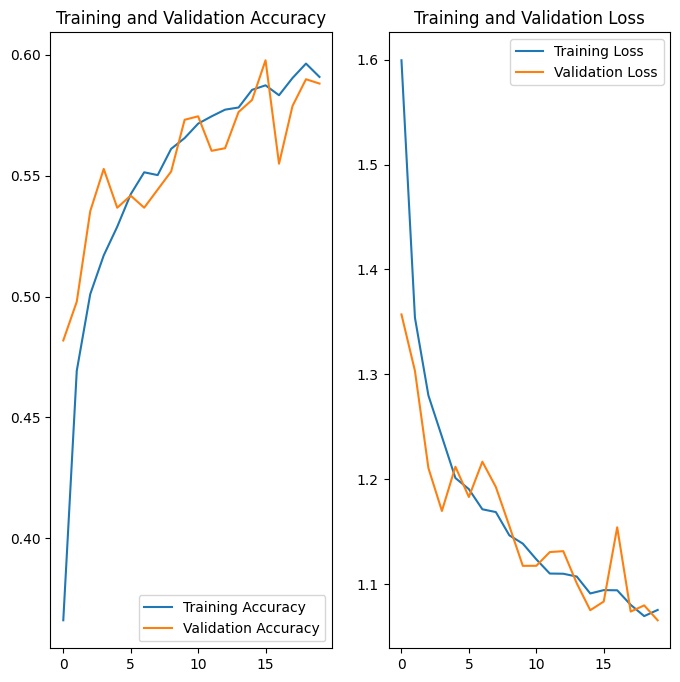

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dnn.history['accuracy']
val_acc = history_dnn.history['val_accuracy']

loss = history_dnn.history['loss']
val_loss = history_dnn.history['val_loss']

epochs_range = range(20)  # Assuming you trained for 20 epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.1.6. Evaluar el modelo en conjunto de test

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_dnn.evaluate(test_generator)
print('Test accuracy:', test_acc)


94/94 [==============================] - 4s 47ms/step - loss: 1.0952 - accuracy: 0.5790
Test accuracy: 0.5789999961853027


#### 3.1.7. Realizar predicciones

In [ ]:
# Get paths of prediction images
prediction_dir = os.path.join(dataset_dir, "seg_pred", "seg_pred")
prediction_image_paths = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]

# Randomly select 5 images for prediction
random_image_paths = random.sample(prediction_image_paths, 5)

plt.figure(figsize=(15, 10))
for i, random_image_path in enumerate(random_image_paths):
    # Load and preprocess the image
    img = load_img(random_image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    predictions = model_dnn.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index]

    # Display the image and prediction
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted class: {predicted_class}')

plt.show()

NameError: name 'model_dnn' is not defined

<Figure size 1500x1000 with 0 Axes>

### 3.2. Redes convolucionales

#### 3.2.1. Definir el modelo

In [ ]:
def build_classification_model_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 6

#### 3.2.2. Connstruir y compilar el modelo

In [ ]:
# Build the CNN model
model_cnn = build_classification_model_cnn(input_shape, num_classes)

# Compile the model
model_cnn.compile(
                  optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

#### 3.2.3. Mostrar el resumen del modelo

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

#### 3.2.4. Entrenar el modelo

In [ ]:
EPOCHS = 20

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
351/351 [==============================] - 690s 2s/step - loss: 1.1056 - accuracy: 0.5626 - val_loss: 0.8699 - val_accuracy: 0.6758
Epoch 2/20
351/351 [==============================] - 689s 2s/step - loss: 0.8111 - accuracy: 0.6960 - val_loss: 0.6938 - val_accuracy: 0.7439
Epoch 3/20
351/351 [==============================] - 685s 2s/step - loss: 0.6920 - accuracy: 0.7484 - val_loss: 0.6098 - val_accuracy: 0.7785
Epoch 4/20
351/351 [==============================] - 680s 2s/step - loss: 0.6068 - accuracy: 0.7786 - val_loss: 0.5450 - val_accuracy: 0.7956
Epoch 5/20
351/351 [==============================] - 649s 2s/step - loss: 0.5615 - accuracy: 0.7981 - val_loss: 0.5320 - val_accuracy: 0.8110
Epoch 6/20
351/351 [==============================] - 691s 2s/step - loss: 0.4969 - accuracy: 0.8229 - val_loss: 0.4561 - val_accuracy: 0.8456
Epoch 7/20
351/351 [==============================] - 658s 2s/step - loss: 0.4732 - accuracy: 0.8306 - val_loss: 0.4753 - val_accuracy: 0.8320

#### 3.2.5. Visualizar Accuracy y Loss de entrenamiento y validación

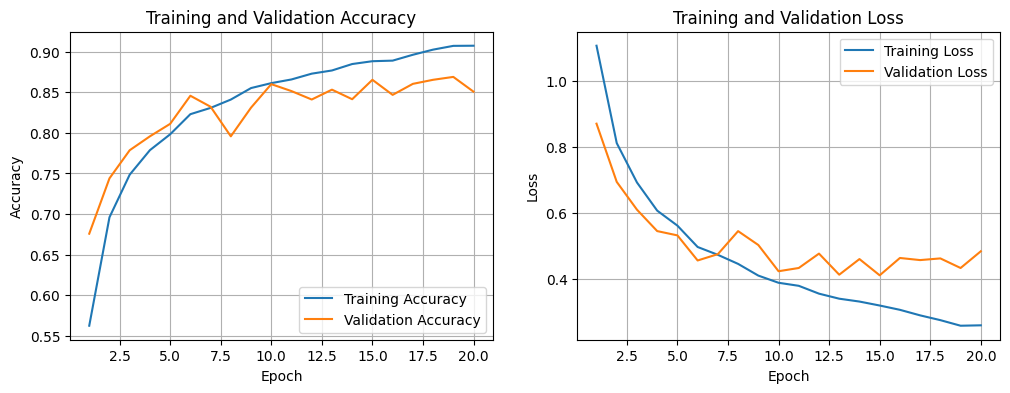

In [ ]:
# Plot accuracy and loss
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()


#### 3.2.6. Evaluar en el conjunto de prueba

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_cnn.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94/94 [==============================] - 39s 418ms/step - loss: 0.4597 - accuracy: 0.8677
Test Loss: 0.4596882462501526
Test Accuracy: 0.8676666617393494


#### 3.2.7. Realizar predicciones

1/1 [==============================] - 0s 57ms/step


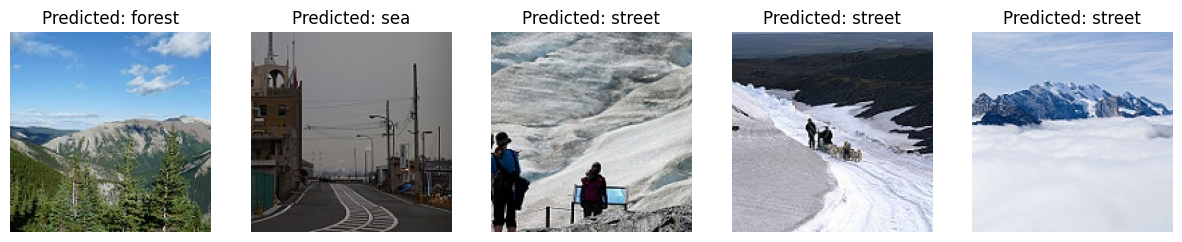

In [ ]:
# Define IMAGE_HEIGHT and IMAGE_WIDTH
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Get some sample images from the prediction set
prediction_image_paths = random.sample(test_generator.filepaths, 5)

# Make predictions on the sample images
predictions = []
for image_path in prediction_image_paths:
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    prediction = model_cnn.predict(img_array)
    predictions.append(prediction.argmax())

# Display the sample images with their predicted labels
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(prediction_image_paths):
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predictions[i]]}")
    plt.axis("off")
plt.show()


### 3.3 - Redes neuronales con bloques ResNet

Se modificará el modelo para incluir bloques de ResNet según la siguiente estructura simplificada

In [ ]:
from PIL import Image

# Cargar la imagen
model_structure_image_path = 'Redes_cnn_con_bloques_ResNet.jpg'
image = Image.open(model_structure_image_path)

# Crear una figura con un tamaño específico
plt.figure(figsize=(15, 8))

# Mostrar la imagen con el nuevo tamaño
plt.imshow(image)
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Redes_cnn_con_bloques_ResNet.jpg'

#### 3.3.1. Se define el bloque ResNet

In [ ]:
# Define the ResNet module
def resnet_module(x, filters):
    # Conv 3x3
    conv = Conv2D(filters=filters[0], kernel_size=(3, 3), activation='relu', padding='same')(x)

    # Conv 3x3
    conv = Conv2D(filters=filters[1], kernel_size=(3, 3), activation='relu', padding='same')(conv)

    # Conv 1x1
    x = Conv2D(filters=filters[1], kernel_size=(1, 1), activation='relu', padding='same')(x)

    # Addition of input and output
    output = Add()([x, conv])

    return output

#### 3.3.2. Se define una función para construir el modelo

In [ ]:
# Define the ResNet model
def cnn_ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_module(x, [64, 32])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_module(x, [32, 96])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_module(x, [96, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1152, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


#### 3.3.3. Se inicializa el modelo

In [ ]:
# Define the input shape
input_shape = (150, 150, 3)
num_classes = 6

# Create the ResNet model
model_resnet = cnn_ResNet(input_shape, num_classes)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 38, 38, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 38, 64)           36928     ['max_pooling2d[0][0]']   

#### 3.3.4. Se compila el modelo

In [ ]:
# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 38, 38, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 38, 38, 64)           36928     ['max_pooling2d[0][0]']   

#### 3.3.5. Se entrena el modelo

In [ ]:
# Train the model
history = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)

Epoch 1/20
350/350 [==============================] - 532s 2s/step - loss: 1.3008 - accuracy: 0.5342 - val_loss: 1.0249 - val_accuracy: 0.5736
Epoch 2/20
350/350 [==============================] - 488s 1s/step - loss: 0.8960 - accuracy: 0.6609 - val_loss: 0.8264 - val_accuracy: 0.6954
Epoch 3/20
224/350 [==================>...........] - ETA: 2:40 - loss: 0.7656 - accuracy: 0.7192

KeyboardInterrupt: 

####3.3.6. Visualizar resultados de entrenamiento

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc_resnet = history.history['accuracy']
val_acc_resnet = history.history['val_accuracy']

loss_resnet = history.history['loss']
val_loss_resnet = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_resnet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_resnet, label='Training Loss')
plt.plot(epochs_range, val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.3.7. Realizar predicciones

In [ ]:
# Directorio de las imágenes de prueba
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener la lista de rutas de las imágenes de prueba
test_image_paths = list(TEST_DATA_DIRECTORY.glob("*.jpg"))

# Lista para almacenar las imágenes cargadas
test_images = []
for image_path in test_image_paths:
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = img_to_array(img)
    # Agregar la imagen al conjunto de datos
    test_images.append(img_array)

# Convertir la lista de imágenes a un array numpy
test_images = np.array(test_images)

In [ ]:
# Evaluar el modelo en el conjunto de validación
val_predictions_resnet = model_cnn_resnet.predict(test_images)
# Obtener clases estimadas (convertir probabilidades a clases)
predicted_classes_resnet = np.argmax(val_predictions_resnet, axis=1)# Evaluar el modelo en el conjunto de validación

####3.3.8. Se visualizan ejemplos de imágenes con sus correspondientes predicciones

In [ ]:
# Obtener las primeras 10 imágenes y sus etiquetas predichas
num_images = 10
sample_images = []
for i in range(0,10):
    image_path = test_image_paths[i]
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    sample_images.append(img)

sample_predicted_labels = np.argmax(val_predictions_resnet[:num_images], axis=1)

# Obtener los nombres de las clases
class_names = ['forest', 'sea', 'mountain', 'street', 'buildings', 'glacier']

# Mostrar las imágenes junto con sus etiquetas predichas
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Predicted: ' + class_names[sample_predicted_labels[i]])
    plt.axis('off')
plt.show()

### 3.4. Transfer Learning

#### 3.4.1. Configuración del Modelo



##### 3.4.1.1. Backbone
Para el backbone hemos escogido MobileNetV2 que es una arquitectura de red neuronal convolucional liviana diseñada para aplicaciones de visión integradas y móviles. Otras razones son:

  * **Eficiencia**: MobileNetV2 es conocido por su eficiencia tanto en términos de tamaño del modelo como de recursos computacionales. Logra un buen equilibrio entre el tamaño y la precisión del modelo, lo que lo hace adecuado para su implementación en dispositivos con recursos limitados.

  * **Preentrenado con ImageNet**: MobileNetV2 está preentrenado con el conjunto de datos de ImageNet, que contiene una gran cantidad de imágenes diversas en varias categorías. Este entrenamiento previo ayuda al modelo a aprender características ricas que son transferibles a otras tareas, incluida la clasificación de escenas naturales en este caso.

  * **Convoluciones separables en profundidad**: MobileNetV2 utiliza convoluciones separables en profundidad, que separan las operaciones espaciales y de canal, lo que reduce la complejidad computacional y mantiene el poder expresivo. Esto lo hace eficiente para dispositivos móviles e integrados.


In [ ]:
# Elegir el modelo preentrenado base (backbone)
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')

# Congelar las capas del modelo preentrenado
base_model.trainable = False


##### 3.4.1.2. Head

1. Capa 2D de agrupación promedio global:

    * La capa Global Average Pooling 2D reduce las dimensiones espaciales de los mapas de características de la red troncal a un único vector tomando el promedio de cada canal del mapa de características.
    * Esto ayuda a reducir la cantidad de parámetros en el modelo y lo hace menos propenso a sobreajustarse.
    * Global Average Pooling retiene la información espacial esencial al tiempo que hace que el modelo sea más robusto a las traducciones espaciales o distorsiones en las imágenes de entrada.

2. Capa Densa (Capa Totalmente Conectada):
    * La capa Densa se agrega para introducir no linealidad y aumentar la capacidad del modelo para capturar patrones complejos en los datos.
    * Consta de 256 neuronas con función de activación ReLU.
    * Se elige ReLU como función de activación porque ayuda a mitigar el problema del gradiente evanescente y acelera la convergencia del proceso de entrenamiento.
    * Se eligen 256 neuronas como un compromiso entre la complejidad y el rendimiento del modelo.

3. Capa de Dropout:
    * El Dropout es una técnica de regularización que elimina aleatoriamente una fracción de neuronas durante el entrenamiento para evitar el sobreajuste.
    * En este caso, se aplica un Dropout del 50 %, lo que significa que la mitad de las neuronas se eliminarán aleatoriamente durante cada iteración de entrenamiento.
    * El Dropout ayuda a mejorar la capacidad de generalización del modelo al obligarlo a aprender características más sólidas.

4. Capa densa de salida:
    * La capa de salida consta de 6 neuronas, correspondientes a las 6 clases (building, forest, glacier, mountain, sea, street).
    * La función de activación utilizada es softmax, que convierte las puntuaciones crudas, producidas por la capa anterior, en probabilidades.
    * Softmax garantiza que las probabilidades de salida sumen 1, lo que lo hace adecuado para tareas de clasificación de clases múltiples.
    * El modelo predice la clase con mayor probabilidad como resultado final.

El Global Average Pooling reduce la dimensionalidad de los mapas de características al tiempo que retiene información importante, lo que hace que el modelo sea computacionalmente eficiente.

Agregar una capa densa con activación ReLU introduce no linealidad y permite que el modelo aprenda patrones complejos en los datos.

El Dropout ayuda a prevenir el sobreajuste al regularizar el modelo durante el entrenamiento.

La capa densa de salida con activación softmax produce probabilidades para cada clase, lo que permite que el modelo realice predicciones precisas de múltiples clases.



In [ ]:
# Añadir nuevas capas encima de modelo preentrenado (head)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### 3.4.2 Entrenamiento del modelo

Ahora, entrenaremos el modelo usando los datos de entrenamiento y lo validaremos usando los datos de validación.

In [ ]:
# Entrenar el modelo (sólo el head se entrenará porque al backbone lo hemos congelado)
history = model.fit(
    train_generator,  # Set de entrenamiento
    steps_per_epoch = train_generator.samples/train_generator.batch_size,  # Definir los steps por epoch
    epochs=10,  # Cantidad de epochs de entrenamiento
    validation_data=validation_generator,  # Set de validación
    validation_steps=validation_generator.samples/validation_generator.batch_size  # Cantidad de steps de valicación
)

#### 3.4.3. Evaluar el modelo en el conjunto de testing

In [ ]:
# Evaluar el modelo en el set de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

#### 3.4.4. Visualización de resultados
Podemos visualizar la precisión y pérdida del entrenamiento y la validación para comprender el rendimiento del modelo.

In [ ]:
# Graficar el accuracy de entrenamiento y validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy de Entrenamiento y validación')
plt.show()

# Graficar el accuracy de entrenamiento y validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss de entrenamiento y validación')
plt.show()


#### 3.4.5. Hacer predicciones con el modelo

In [ ]:
# Ruta del cirectorio que contiene las imágenes para predicción
prediction_dir = "/content/TP1-3/seg_pred/seg_pred/"

# Obtener una lista de todas las imágenes en el directorio de predicción
image_files = os.listdir(prediction_dir)

# Elegir una imagen al azar
random_image_file = np.random.choice(image_files)

# Cargar la imagen y preprocesarla
img_path = os.path.join(prediction_dir, random_image_file)
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Reescalar los píxeles al reango [0, 1]

# Mostrar la imagen
plt.imshow(img)
plt.axis('off')
plt.show()

# Hacer la predicción
predictions = model.predict(img_array)

# Obtener la clase predicha
predicted_class = np.argmax(predictions[0])

# Mapear el índice de la clase a la etiqueta de la clase
class_labels = train_generator.class_indices
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Clase predicha:", predicted_label)

## 4. Comparación